# 1. Denoising with Total Variation

We aim for solving the TV denoising problem

$$
    \min_{x \geq 0} \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_1 \right]
$$

for given data $y$ and some regularization parameter $\alpha > 0$. 

We optimize over all *pointwise nonnegative* $x$, but since that set is not a vector space, we have to use the **indicator function**

$$
    \iota_0(x)(t) =
    \begin{cases}
        0,      &\text{if } x(t) >= 0, \\
        \infty, &\text{if } x(t) < 0
    \end{cases}
$$

leading to a new formulation

$$
    \min_x \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_1 + \iota_0(x) \right].
$$


## The Douglas-Rachford solver

We will use the Douglas-Rachford splitting based method, which can solve problems of the form

$$
    \min_{x \in X} \left[ f(x) + \sum_{i=1}^n g_i (L_i x) \right]
$$

with convex functions $f$, $g_1, \dots, g_n$ and linear operators $L_1, \dots, L_n$.

We can choose the functions

$$
    f = \iota_0,\quad g_1 = \|\cdot - y\|_2^2, \quad g_2 = \|\cdot\|_1,
$$

and the linear operators

$$
    L_1 = I, \quad L_2 = \nabla.
$$

### Parameter selection

The method is guaranteed to converge if optimization parameters $\tau$ and $\sigma_1, \dots, \sigma_n$ are chosen such that

$$
    \tau \sum_{i=1}^n \sigma_i \|L_i\|^2 < 4.
$$

In our case, we have three parameters $\tau, \sigma_1, \sigma_2$. As a rule of thumb, it often makes sense to have the $\sigma_i$ parameters balance the operator norms, i.e., to choose

$$
    \sigma_i = c \|L_i\|^{-2},
$$

and to select $\tau$ such that the sum converges, i.e.,

$$
    \tau < \frac{4}{nc}.
$$


## Implementation

We will use the ["ascent" test image from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.ascent.html) with additive white noise (since that is what $\|\cdot - y\|_2^2$ is suitable for).

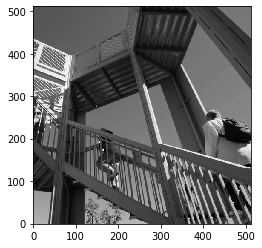

In [1]:
%matplotlib inline
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt

import odl

# Generate test image
image = scipy.misc.ascent().astype('float32')
image = np.rot90(image, -1)  # Change axis convention
image /= image.max() # normalize

# We use a semicolon at the end to avoid the figure being shown twice
plt.imshow(image.T, cmap='gray', origin='lower');

Now we define the reconstruction space $X$. In ODL, spaces are defined as cuboids $Q = [a, b]$, where $a, b \in \mathbb{R}^d$ with $a \leq b$ entry-wise.
For discretization, the number $N \in \mathbb{N}^d$ of points per axis needs to be specified. This is called the *shape* of the space (as for NumPy arrays). 

Now, a continuous function $x$ is represented by its discrete values $x_i = x(t_i)$, where

$$
    t_i = t_0 + i \Delta t,\quad 0 \leq i < N,\ t_0, \Delta t \in \mathbb{R}^d,
$$

are uniform samples from the cuboid $[a, b]$ (note that addition and multiplication above are componentwise).

In two dimensions, for instance, this is a way of interpreting an image $x \in \mathbb{R}^{N_1 \times N_2}$ as a discretized function on some rectangle $[a_1, b_1] \times [a_2, b_2]$.
For our example, we choose $a = 0$ and $b = N$ to make each pixel have size $1 \times 1$.

In [2]:
# `min_pt` corresponds to `a`, `max_pt` to `b`
X = odl.uniform_discr(min_pt=[0, 0], max_pt=image.shape, shape=image.shape)

print('Pixel size:', X.cell_sides)

Pixel size: [ 1.  1.]


 Now we make the (rescaled) image an element $x_{\mathrm{true}} \in X$ and define the noisy image $y = x_{\mathrm{true}} + 0.1 \cdot N(0, 1)$ as a space element, too.

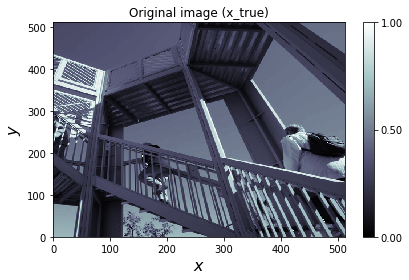

<Figure size 432x288 with 0 Axes>

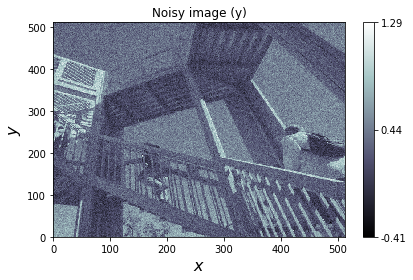

<Figure size 432x288 with 0 Axes>

In [3]:
# Convert "image" from numpy array into an ODL vector
x_true = X.element(image)

# To get predictable randomness, we explicitly seed the random number generator
y = x_true + 0.1 * odl.phantom.white_noise(X, seed=42)

x_true.show(title='Original image (x_true)');
y.show(title='Noisy image (y)');

Now we set up the parts of the problem:

In [4]:
f = odl.solvers.IndicatorNonnegativity(X)
ident = odl.IdentityOperator(X)

grad = odl.Gradient(X)
print('Gradient domain X:', grad.domain)
print('Gradient range X^d:', grad.range)

Gradient domain X: uniform_discr([ 0.,  0.], [ 512.,  512.], (512, 512))
Gradient range X^d: (uniform_discr([ 0.,  0.], [ 512.,  512.], (512, 512))) ** 2


Note that we don't have to set up the output space explicitly since the `odl.Gradient` operator does it for us.

In [5]:
# Functions to be composed with linear operators.
alpha = 0.15
g = [odl.solvers.L2NormSquared(X).translated(y),
     alpha * odl.solvers.L1Norm(grad.range)]
L = [ident, grad]

# We check if everything makes sense by evaluating the total functional at 0
x = X.zero()
print(f(x) + sum(g[i](L[i](x)) for i in range(len(g))))

43076.96185254053


Now we can invoke the solver with the problem components as defined above. To guarantee convergence, the step-size-like parameters $\tau$ (primal step) and $\sigma$ (dual steps) need to be chosen properly. Conditions like these are always documented in ODL and we can type `? odl.solvers.douglas_rachford_pd` in a code cell to find the documentation.

In [6]:
? odl.solvers.douglas_rachford_pd

Where we find the criterion

$$
      \tau \sum_{i=1}^n \sigma_i \|L_i\|^2 < 4
$$

Here, $\|L\|$ is the *operator norm* of $L$, like the Frobenius norm of a matrix. We have a tool to estimate this norm. It uses the [Power Method](https://en.wikipedia.org/wiki/Power_iteration):

In [7]:
grad_norm = 1.1 * odl.power_method_opnorm(grad, xstart=y, maxiter=20)
opnorms = [1, grad_norm]  # identity has norm 1
print(opnorms)

[1, 3.0293052066245845]


Now we set the $\tau$ and $\sigma_i$ parameters for the optimization. We use a small function to make it easier to check if the parameters work. To make the parameter search space smaller, we choose $\tau$ (primal step size) and select

$$
    \sigma_i = \frac{c}{\|L_i\|^2}, \quad c = \frac{3}{n \tau}
$$

with $n = 2$ in our case.

In [8]:
def check_params(tau, sigmas):
    sum_part = sum(sigma * opnorm ** 2
                   for sigma, opnorm in zip(sigmas, opnorms))
    print('Sum evaluates to', sum_part)
    check_value = tau * sum_part
    
    assert check_value < 4, 'value must be < 4, got {}'.format(check_value)
    print('Values ok, check evaluates to {}, must be < 4'.format(check_value))
    

tau = 1.5
c = 3.0 / (len(opnorms) * tau)
sigmas = [c / opnorm ** 2 for opnorm in opnorms]
check_params(tau, sigmas)

Sum evaluates to 2.0
Values ok, check evaluates to 3.0, must be < 4


Now we're finally ready to run the solver!

In [9]:
# Starting point
x = X.zero()

# Run the DR method. The vector `x` is updated in-place.
odl.solvers.douglas_rachford_pd(x, f, g, L, niter=200, tau=tau, sigma=sigmas)

We can now visually investigate the result, or we can apply quality measures (Figures of Merit, FOMs) from the `odl.contrib.fom` subpackage:

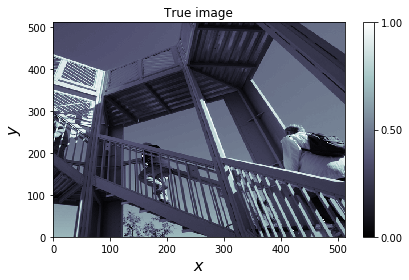

<Figure size 432x288 with 0 Axes>

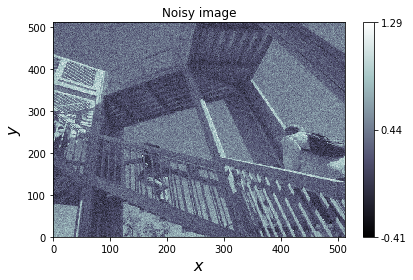

<Figure size 432x288 with 0 Axes>

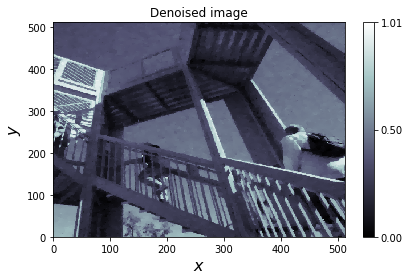

<Figure size 432x288 with 0 Axes>

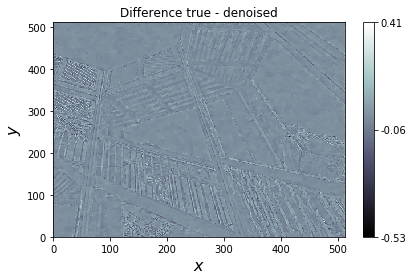

<Figure size 432x288 with 0 Axes>

In [10]:
x_true.show('True image');
y.show('Noisy image');
x.show('Denoised image');
(x_true - x).show('Difference true - denoised');

In [11]:
from odl.contrib import fom

print('Noisy')
print('-----')
print('Mean squared error:', fom.mean_squared_error(y, x_true))
print('PSNR:', fom.psnr(y, x_true))
print('SSIM:', fom.ssim(y, x_true))
print('')

print('Denoised')
print('--------')
print('Mean squared error:', fom.mean_squared_error(x, x_true))
print('PSNR:', fom.psnr(x, x_true))
print('SSIM:', fom.ssim(x, x_true))

Noisy
-----
Mean squared error: 0.009997884750280165
PSNR: 20.0009187385
SSIM: 0.338106082677

Denoised
--------
Mean squared error: 0.0016266507301534445
PSNR: 27.8870568754
SSIM: 0.845012112527


## References

[BC2015] Bot, R I, and Csetnek, E R. *On the convergence rate of a forward-backward type primal-dual splitting algorithm for convex optimization problems*. Optimization, 64.1 (2015), pp 5--23.

[BH2013] Bot, R I, and Hendrich, C. *A Douglas-Rachford type primal-dual method for solving inclusions with mixtures of     composite and parallel-sum type monotone operators*. SIAM Journal on Optimization, 23.4 (2013), pp 2541--2565.

# 2. Tomography with Total Variation

Instead of denoising, solve the TV-regularized tomography problem

$$
    \min_{x \geq 0} \left[ \| A x - y \|_2^2 + \alpha \| \nabla x \|_1 \right],
$$

where $A$ is the ray transform.

Since we are delaing with tomography let's use a Shepp-Logan Phantom. It can be sampled in the domain space $X$. 


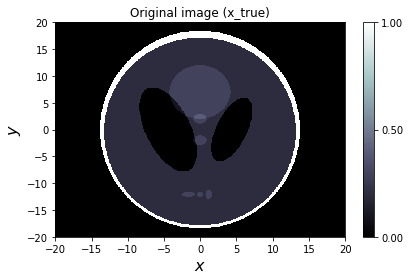

<Figure size 432x288 with 0 Axes>

In [12]:
X = odl.uniform_discr(min_pt=[-20, -20], max_pt=[20, 20], shape=[512, 512], dtype='float32')

image = odl.phantom.shepp_logan(X, modified=True)
x_true = X.element(image)
x_true.show(title='Original image (x_true)');

Setting up a [`odl.tomo.RayTransform`](https://odlgroup.github.io/odl/generated/odl.tomo.operators.ray_trafo.RayTransform.html) with [`odl.tomo.parallel_beam_geometry`](https://odlgroup.github.io/odl/generated/odl.tomo.geometry.parallel.parallel_beam_geometry.html).

- It is possible to chose different back-ends, the ASTRA toolbox as backend if possible.

- The data fit $\|\cdot -y\|_2^2$ is now defined on a different space than before, and also $y$ is no longer an element of the reconstruction space $X$.

/home/zhenja/anaconda3/envs/leiden/lib/python3.7/site-packages/odl/tomo/operators/ray_trafo.py:144: RuntimeWarning: The best available backend ('skimage') may be too slow for volumes of this size. Consider using ASTRA. This warning can be disabled by explicitly setting `impl='skimage'`.
  RuntimeWarning)


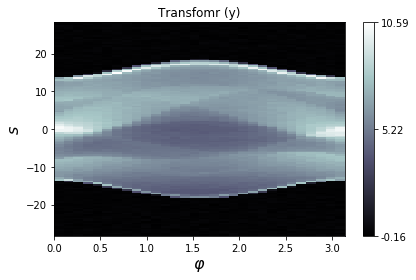

<Figure size 432x288 with 0 Axes>

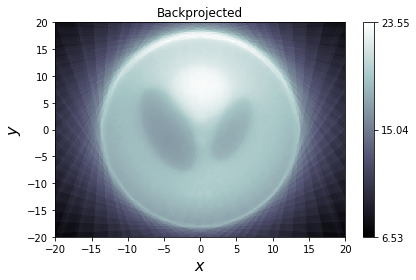

<Figure size 432x288 with 0 Axes>

In [13]:
geometry = odl.tomo.parallel_beam_geometry(X, num_angles=30, det_shape=128)
A = odl.tomo.RayTransform(X, geometry)

# To get predictable randomness, we explicitly seed the random number generator
y = A(x_true) + 0.05 * odl.phantom.white_noise(A.range, seed=42)
    
y.show(title='Transfomr (y)');
backproj = A.adjoint(y)
backproj.show(title = 'Backprojected', force_show=True);

Solve the TV-regularized tomography problem.

In [14]:
grad = odl.Gradient(X)  # need this here for L1Norm below

# Function without linear operator
f = odl.solvers.IndicatorNonnegativity(X)

# Functions to be composed with linear operators. L[i] applies to g[i].
alpha = 0.15
g = [odl.solvers.L2NormSquared(A.range).translated(y),
     alpha * odl.solvers.L1Norm(grad.range)]
L = [A, grad]

# We check if everything makes sense by evaluating the total functional at a starting point
x = X.zero()
print(f(x) + sum(g[i](L[i](x)) for i in range(len(g))))

3936.9698910889724


In [15]:
grad_norm = 1.1 * odl.power_method_opnorm(grad, maxiter=20)
A_norm = 1.1 * odl.power_method_opnorm(A, maxiter=20)
opnorms = [A_norm, grad_norm]  # identity has norm 1
print("Operator norms:", opnorms)
    
tau = 1.5
c = 3.0 / (len(opnorms) * tau)
sigmas = [c / opnorm ** 2 for opnorm in opnorms]
check_params(tau, sigmas)

Operator norms: [12.14543756763879, 38.763010560344981]
Sum evaluates to 2.0
Values ok, check evaluates to 3.0, must be < 4


In [31]:
# Run the DR method. The vector `x` is updated in-place.
odl.solvers.douglas_rachford_pd(x, f, g, L, niter=200, tau=tau, sigma=sigmas)

Showing the results

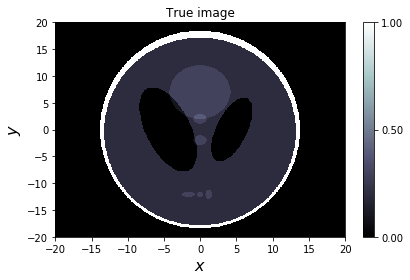

<Figure size 432x288 with 0 Axes>

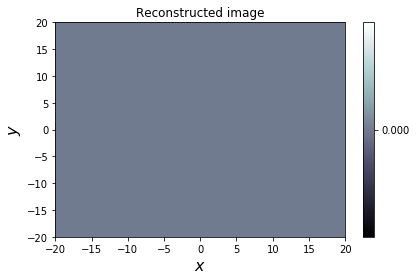

<Figure size 432x288 with 0 Axes>

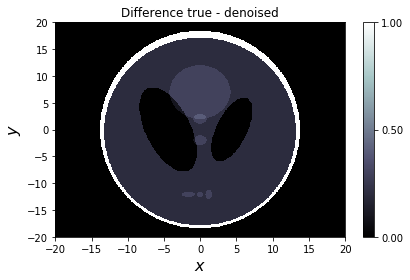

<Figure size 432x288 with 0 Axes>

Denoised
--------
Mean squared error: 0.06097642332315445
PSNR: 12.1483805351
SSIM: 0.52986159248


In [16]:
x_true.show('True image');
x.show('Reconstructed image');
(x_true - x ).show('Difference true - denoised');

from odl.contrib import fom

print('Denoised')
print('--------')
print('Mean squared error:', fom.mean_squared_error(x, x_true))
print('PSNR:', fom.psnr(x, x_true))
print('SSIM:', fom.ssim(x, x_true))

Using an analytic reconstruction method, e.g. [`odl.tomo.fbp_op`](https://odlgroup.github.io/odl/generated/odl.tomo.analytic.filtered_back_projection.fbp_op.html).

In [21]:
? odl.tomo.fbp_op

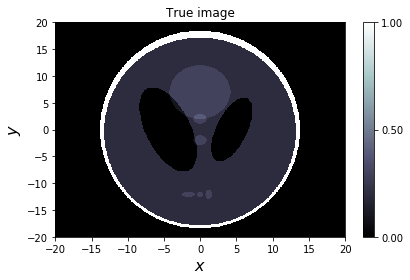

<Figure size 432x288 with 0 Axes>

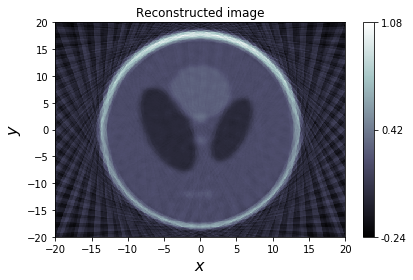

<Figure size 432x288 with 0 Axes>

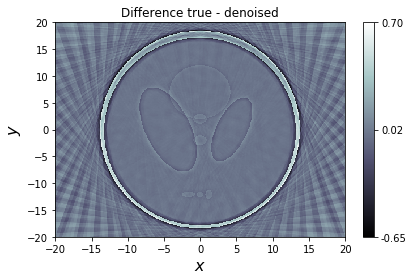

<Figure size 432x288 with 0 Axes>

Denoised
--------
Mean squared error: 0.012856977991759777
PSNR: 18.9086109951
SSIM: 0.423233047483


In [24]:
fbp = odl.tomo.fbp_op(A, filter_type='Hann', frequency_scaling=1.0)

x_fbp = fbp(y)
x_true.show('True image');
x_fbp.show('Reconstructed image');
(x_true - x_fbp).show('Difference true - denoised');

print('Denoised')
print('--------')
print('Mean squared error:', fom.mean_squared_error(x_fbp, x_true))
print('PSNR:', fom.psnr(x_fbp, x_true))
print('SSIM:', fom.ssim(x_fbp, x_true))